In [20]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dropout, Dense, Flatten,GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from itertools import chain


In [10]:
file_path = 'corpus_all.txt'  # Replace with the actual path to your text file

lines = []  # Empty list to store the lines

try:
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            lines.append(line.strip())  # Append the line to the list, removing any leading/trailing whitespace

except FileNotFoundError:
    print("File not found. Please check the file path and try again.")

#file_path = 'corpus_all.txt'  # Replace with the actual path to your text file
first_words = []  # Empty list to store the first words

try:
    for line in lines:
        words = line.strip().split()  # Split the line into words
        if words:
            first_word = words[0]  # Get the first word
            first_words.append(first_word)  # Append the first word to the list

except FileNotFoundError:
    print("File not found. Please check the file path and try again.")


# Define the status levels
status_levels = ["happy","angry","fear","disgust","sad","surprise",]

# Initialize a list to store the extracted status levels and sentences
extracted_data = []

# Iterate over the texts
for text in lines:
    # Initialize variables to store the extracted status level and sentence
    status = ""
    sentence = ""

    # Iterate over the status levels
    for level in status_levels:
        if level in text:
            # Split the text based on the status level
            split_text = text.split(level, 1)

            # Extract the status level and sentence
            status = level
            sentence = split_text[1].strip()
            break

    # Append the extracted status level and sentence to the list
    extracted_data.append({"Status": status, "Sentence": sentence})
    
df = pd.DataFrame(extracted_data)

In [11]:
df

,Status,Sentence
0,sad,"বরাবর, মাননীয় প্রধানমন্ত্রী গণপ্রজাতন্ত্রী বা..."
1,sad,তদন্ত করে লাভ কী ? কোন দিন কোন তদন্তের পর কিছু...
2,angry,দেশকি মধ্যম আয়ের দেশে রুপান্তর হচ্ছে নাকি মগের...
3,happy,আমি গর্বিত আমি মুসলিম। আমি সংগ্রামী। আমি যোদ্ধ...
4,angry,রাতের বেলা আবার কিসের সকাল।
...,...,...
6284,surprise,ভারতে প্রতিদিন ১৮ টা রেপ কেইস এন্ট্রি হয়
6285,surprise,এই কি স্বাধীন দেশ
6286,sad,স্বাধীন দেশের নাগরিক হয়ে ও আজ আমরা পরাধীন।
6287,angry,চুদলাম দাদা পয়সা নাই


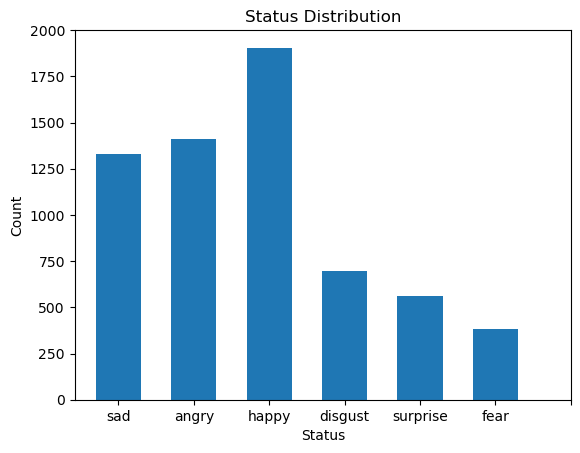

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(df['Status'], bins=[0, 1, 2, 3, 4, 5, 6], align='left', rwidth=0.6)
plt.xticks([0, 1, 2, 3, 4, 5, 6])
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Status Distribution')
plt.show()

In [28]:
# Separate sentences and sentiments
sentences = df['Sentence'].values
sentiments = df['Status'].values

# Map sentiment labels to numerical values
sentiment_mapping = {'happy': 0, 'angry': 1, 'fear': 2, 'disgust': 3, 'sad': 4, 'surprise': 5}
sentiments = [sentiment_mapping[s] for s in sentiments]

# Split the data into training and testing sets
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, sentiments, test_size=0.2, random_state=42)

# Set the maximum number of words to keep in the vocabulary
max_words = 5000

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(sentences_train)

# Convert sentences to sequences of integers
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences to ensure they have the same length
max_sequence_length = max(len(seq) for seq in X_train)
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

# Convert sentiment labels to one-hot encoded vectors
y_train = to_categorical(y_train,6)
y_test = to_categorical(y_test,6)


In [39]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train:", X_train)
print("y_train:", y_train)

X_train shape: (5031, 583)
y_train shape: (5031, 6)
X_train: [[   0    0    0 ...    0    0   24]
 [   0    0    0 ...   29  273  192]
 [   0    0    0 ...    9  528 4111]
 ...
 [   0    0    0 ...  526  250 4055]
 [   0    0    0 ...  776  148 1898]
 [   0    0    0 ...  803 1073  105]]
y_train: [[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]]


In [37]:
# Create the CNN model
max_len=100
embedding_dim = 100  # Adjust this based on your word embeddings dimension
vocab_size = len(tokenizer.word_index) + 1  # +1 for the unknown token
sequence_length = max_len  # Adjust this based on your maximum sentence length

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [38]:

# Train the model
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10


ValueError: in user code:

    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\ProgramData\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 100), found shape=(None, 583)
